## P47 Wormhole 
- Cleaned up version w/ original param replacement bug fix

In [1]:
# ! pip install transformers matplotlib tqdm huggingface_hub

In [2]:
# from huggingface_hub import login
# login()

In [3]:
import torch
from transformers import pipeline
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import copy
from collections import OrderedDict

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

device='cuda'

In [4]:
# model_id = "meta-llama/Llama-3.2-1B"
# model_id = "openai-community/gpt2"
# model_id = "google/gemma-3-1b-pt"
model_id = "gpt2"

#Pretrained
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.eval();

## Configuration for this run

In [5]:
# output_dir='/workspace/may_6_1'
output_dir='/home/stephen/backparopagation/may_6_5_gpt2'
num_points=32

In [6]:
os.makedirs(output_dir, exist_ok=True)

## Support Functions

In [7]:
def get_random_directions(params, seed=None):
    """
    Generate random direction vectors for each parameter tensor.
    
    Args:
        params: List of (name, parameter) tuples from model.named_parameters()
        seed: Random seed for reproducibility
        
    Returns:
        direction: OrderedDict mapping parameter names to random direction tensors
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    direction = OrderedDict()
    for name, param in params:
        if param.requires_grad:
            direction[name] = torch.randn_like(param.data)
    
    return direction

def normalize_direction(direction, params):
    """
    Normalize the direction tensors to match the norm of each parameter tensor.
    
    Args:
        direction: OrderedDict mapping parameter names to direction tensors
        params: List of (name, parameter) tuples from model.named_parameters()
        
    Returns:
        normalized_direction: OrderedDict with normalized direction tensors
    """
    param_dict = OrderedDict(params)
    normalized_direction = OrderedDict()
    
    for name, dir_tensor in direction.items():
        param_norm = torch.norm(param_dict[name].data)
        dir_norm = torch.norm(dir_tensor)
        
        # Avoid division by zero
        if dir_norm > 0:
            normalized_direction[name] = dir_tensor * (param_norm / dir_norm)
        else:
            normalized_direction[name] = dir_tensor
    
    return normalized_direction

### Setup example and run some Computation Checks

In [8]:
text = "The capital of France is Paris"
inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

In [9]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()
print(my_loss.item(), outputs.loss.item())

3.3751838207244873 3.3751838207244873


In [10]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()

paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
print(my_loss.item(), outputs.loss.item(), paris_only_loss)

3.3751838207244873 3.3751838207244873 0.9376916737061879


In [11]:
sI=np.argsort(my_probs[0,5, :].detach().cpu().float().numpy())[::-1]
for i in sI[:10]:
    print(i, round(my_probs[0, 5, i].item(),5), tokenizer.decode([i]))

12366 0.39153  Paris
264 0.08419  a
279 0.0704  the
832 0.03096  one
1101 0.03061  also
2162 0.02528  home
3967 0.02462  known
539 0.01659  not
459 0.01241  an
7559 0.01172  located


In [12]:
prefix='pretrained_'
filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
# layers_name='all'

# layers_name='first_8'
# filtered_params = filtered_params[1:73] 

# layers_name='last_8'
# filtered_params = filtered_params[73:] #Last 8 layers - some nice structue, but yeah more parabolic than I would like

In [13]:
random_seeds_pairs=[[o, o+100] for o in range(25)]

0 100


100%|████████████████████████████████████████████████████| 32/32 [00:33<00:00,  1.04s/it]


1 101


100%|████████████████████████████████████████████████████| 32/32 [00:33<00:00,  1.05s/it]


2 102


100%|████████████████████████████████████████████████████| 32/32 [00:36<00:00,  1.14s/it]


3 103


  3%|█▋                                                   | 1/32 [00:01<00:35,  1.15s/it]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

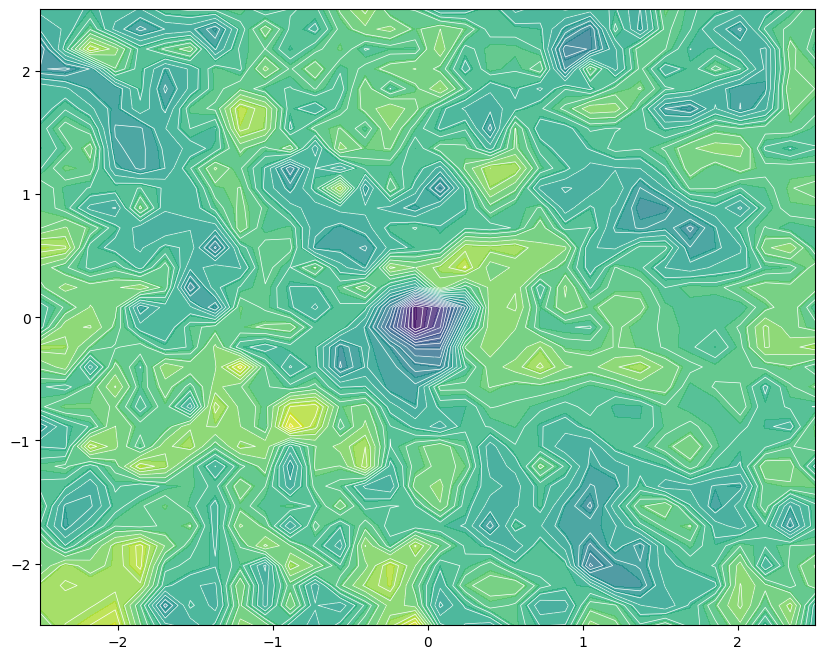

In [14]:
for random_seed_1, random_seed_2 in random_seeds_pairs:
    print(random_seed_1, random_seed_2)

    # Generate and normalize random directions
    direction1 = get_random_directions(filtered_params, seed=random_seed_1)
    direction2 = get_random_directions(filtered_params, seed=random_seed_2)
    
    direction1 = normalize_direction(direction1, filtered_params)
    direction2 = normalize_direction(direction2, filtered_params)
    
    original_params = OrderedDict()
    for name, param in filtered_params:
        original_params[name] = param.data.clone()
    
    alphas=np.linspace(-2.5, 2.5, num_points)
    betas=np.linspace(-2.5, 2.5, num_points)
    
    losses=[]
    
    model.eval();
    with torch.no_grad():
        for i, alpha in enumerate(tqdm(alphas)):
            losses.append([])
            for j, beta in enumerate(betas):
                for name, param in model.named_parameters():
                    if name in direction1:
                        param.data = original_params[name] + alpha * direction1[name] + beta*direction2[name]
                
                outputs = model(input_ids, labels=input_ids)
                my_probs=F.softmax(outputs.logits, dim=-1)
                paris_only_loss=-np.log(my_probs[0, 5, 12366].item()) #Just Paris
                # losses[-1].append(paris_only_loss)
                losses[-1].append(outputs.loss.item()) #all 5 losses averaged
        
        for name, param in model.named_parameters(): # Restore original shifted parameters
            if name in original_params: 
                param.data.copy_(original_params[name])
        losses=np.array(losses)
    
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    contourf = ax.contourf(alphas, betas, losses, 20, cmap='viridis', alpha=0.8)
    contour = ax.contour(alphas, betas, losses, 30, colors='white', linewidths=0.5)
    plt.savefig(output_dir+'/'+layers_name+'_'+str(random_seed_1)+'_'+str(random_seed_2)+'.png')
    np.save(output_dir +'/'+layers_name+'_'+str(random_seed_1)+'_'+str(random_seed_2), losses) #Save loss landscape

In [ ]:
# os.makedirs(output_dir, exist_ok=True)

In [ ]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 8))
contourf = ax.contourf(alphas, betas, losses, 20, cmap='viridis', alpha=0.8)
contour = ax.contour(alphas, betas, losses, 30, colors='white', linewidths=0.5)
# plt.savefig(output_dir +'/'+str(step).zfill(3)+'.png')

In [ ]:
# np.save(output_dir +'/'+str(step).zfill(3), losses) #Save loss landscape

In [ ]:
plt.imshow(losses)

In [ ]:


    # with torch.no_grad(): #Check current outputs
    #     outputs = model(input_ids, labels=input_ids)
    #     my_probs=F.softmax(outputs.logits, dim=-1)
    #     sI=np.argsort(my_probs[0,5, :].detach().cpu().float().numpy())[::-1]
    #     current_outs=[[12366,  round(my_probs[0, 5, 12366].item(), 7), ' Paris']] #Put paris at top
    #     for i in sI[:10]:
    #         current_outs.append([i, round(my_probs[0, 5, i].item(),7), tokenizer.decode([i])])
    #     model_outputs.append(current_outs)
    #     print(step, 'loss=', -np.log(my_probs[0, 5, 12366].item()), current_outs[0], current_outs[1])

    # if step>=delayed_viz_start: #Do I want to compute loss landscape at this step?
    #     with torch.no_grad():
    #         for i, alpha in enumerate(tqdm(alphas_shifted)):
    #             losses.append([])
    #             for j, beta in enumerate(betas_shifted):
    #                 for name, param in model.named_parameters():
    #                     if name in direction1:
    #                         param.data = original_params_shifted[name] + alpha * direction1[name] + beta*direction2[name]
                    
    #                 outputs = model(input_ids, labels=input_ids)
    #                 my_probs=F.softmax(outputs.logits, dim=-1)
    #                 paris_only_loss=-np.log(my_probs[0, 5, 12366].item()) #Just Paris
    #                 losses[-1].append(paris_only_loss)
            
    #         for name, param in model.named_parameters(): # Restore original shifted parameters
    #             if name in original_params: 
    #                 param.data.copy_(original_params_shifted[name])
    #     losses=np.array(losses)
    #     np.save(output_dir +'/'+str(step).zfill(3), losses) #Save loss landscape
        
    #     plt.clf()
    #     fig, ax = plt.subplots(figsize=(10, 8))
    #     contourf = ax.contourf(alphas, betas, losses, 20, cmap='viridis', alpha=0.8)
    #     contour = ax.contour(alphas, betas, losses, 30, colors='white', linewidths=0.5)
    #     plt.scatter(beta_shift, alpha_shift, c='m')
    #     plt.savefig(output_dir +'/'+str(step).zfill(3)+'.png')

    # model.train()
    # optimizer.zero_grad()
    # outputs = model(**inputs, labels=inputs['input_ids'])
    # loss = outputs.loss #Ok not just paris loss here -> not sure how much I'm worried about that
    # loss.backward()
    # optimizer.step()

    # #After training I need to replace original_params_shifted with the new trained values
    # original_params_shifted = OrderedDict()
    # for name, param in filtered_params:
    #     original_params_shifted[name] = param.data.clone()